# Predicting Pakistan Super League (PSL) Matches using Random Forest Classification

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from extract_match import extract_match_data # custom function to extract match data for training/validation
from new_matches import get_match # custom function to extract match data for testing

## Extract Training/Validation data

* **Extract the data for all the matches.** *(From PSL:S01 to PSL:S06[Up-to Match#14])* 
* **Matches with no-result or matches decided on D/L method are discared.** *(5 Matches)*
* **Tied matches are treated as 'win' for both teams.**
* **Team batting first is referred to as Team1, and Team batting second is referred to as Team2**

**Following features were extracted:**
* Run-rate in powerplay for Team1 (*PP_rr*)
* Wickets remaining after powerplay for Team1 (*PP_wkt_rem*)
* Run-rate in overs 6-15 for Team1 (*mid_rr*)
* Wickets remaining after overs 6-15 for Team1 (*mid_wkt_rem*)
* Overall run-rate for Team1 after first innings (*RR*)
* Match result w.r.t. Team1 (*Win*)

* Required Run-rate after each over for Team2 (*rrr_T2*)
* Wickets remaining after each over for Team2 (*T2_wkt_rem*)

In [2]:
filenames = glob.glob('*.csv')

[team1_data, team2_data] = extract_match_data(filenames)

df1 = pd.DataFrame(team1_data)

df1.columns = ['PP_rr', 'PP_wkt_rem', 'mid_rr', 'mid_wkt_rem','RR','Win']

C:\Users\ammar\Downloads\psl_csv\extract_match.py:60: RuntimeWarning: divide by zero encountered in true_divide
  team2_rrr = (team1_runs + 1 - team2_runs)/b


## Training/validation using Team1 data only

* **First we use Team 1 data only to train a *Random Forest Classifier*.**
* **We use SMOTE to oversample the minority class because the original data is imbalanced with team batting once winning only 52 times out of 155**.
* **We use 80-20 train-test split**.
* **We compute Prediction Accuracy, Average Precision Score, and Reciever-operating-curve Area-under-the-curve (AUC-ROC) score, for the held out data**

In [3]:
X = df1.values[:,:-1]
y = df1.values[:,-1]

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

clf = RandomForestClassifier(random_state=42).fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('\n','Accuracy:',clf.score(X_test,y_test),'\n','Precision:',average_precision_score(y_test,y_pred),'\n', 'ROC_AUC:',roc_auc_score(y_test,y_pred))


 Accuracy: 0.8095238095238095 
 Precision: 0.7422360248447206 
 ROC_AUC: 0.8095238095238095


**Results look plausible to me atleast, considering we only use 5 features.**

## Incorporating Team2 data

**In a match scenario, we expect the situation to evolve with the progression of overs. Therefore, here we use data two features from Team2 data after every over, i.e. Required Run-rate after each over for Team2 (rrr_T2) and Wickets remaining after each over for Team2 (T2_wkt_rem)**.

**This means for after every over new model would have to be trained.**

In [6]:
def situational_model(overnum, seed):
    t = overnum-1
    df2 = pd.DataFrame(np.hstack([team1_data, team2_data[:,[t*2, (t*2)+1]]]))

    df2.columns = ['PP_rr', 'PP_wkt_rem', 'mid_rr', 'mid_wkt_rem','RR','Win', 'rrr_T2', 'T2_wkt_rem']

    X = df2.values[:,[0,1,2,3,4,6,7]]
    y = df2.values[:,5]
    X[X==np.inf] = 10000

    sm = SMOTE(random_state=42)

    X_res, y_res = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

    clf2 = RandomForestClassifier(random_state=seed).fit(X_train,y_train)
#    clf2 = RandomForestClassifier(random_state=42).fit(X_res,y_res)
#    y_pred = clf2.predict(X_test)

#    print('\n','Accuracy:',clf2.score(X_test,y_test),'\n','Precision:',average_precision_score(y_test,y_pred),'\n', 'ROC_AUC:',roc_auc_score(y_test,y_pred))
    
    return(clf2)

## Testing

**Now we test the performance of our model on the present matches of PSL:S06 {from Match#15 onwards}.**

**First the prediction is made after the end of Innings#1, using Team1 data only**

**After that the prediction is made after every over of Innings#2, using required run-rate and wickets remaining as additional features.**

**Due to the stochastic nature of Random Forest Classifier, the results depend on random seed. Therefore we train the models 100 times using different random seeds, and average the results.**

For testing the present matches change the ***num*** variable according to the match number after PSL resumed.

* num=1, for Islamabad United (IU) vs Lahore Qalandars (LQ)
* num=2, for Multan Sultans (MS) vs Karachi Kings (KK)
* num=3, for Lahore Qalandars (LQ) vs Peshawar Zalmi (PZ)
* num=4, for Quetta Gladiators (QG) vs Islamabad United (IU)
* num=5, for Peshawar Zalmi (PZ) vs Quetta Gladiators (QG)
* num=6, for Islamabad United (IU) vs Lahore Qalandars (LQ)
* num=7, for Peshawar Zalmi (PZ) vs Multan Sultans (MS)

**PS: The data for current matches has to be added manually in *new_matches.py* file.**

In [7]:
[Team1, Team2, match] = get_match(num=7)
Team1_prob = list()
Team2_prob = list()
RRR = list()
Wkts = list()


win_p = clf.predict_proba(match[:,0:5])
print('After 1st Innings')
print ('Win Probablity for %s: %.2f'%(Team1,win_p[0][1]))
print ('Win Probablity for %s: %.2f'%(Team2,1-win_p[0][1]))
print ('Required Run Rate: %.2f, Wickets Remaining: %d'%((match[:,4]+0.05),10))

Team1_prob.append(win_p[0][1])
Team2_prob.append(win_p[0][0])
RRR.append(match[:,4]+0.05)
Wkts.append(np.array([10]))

for over in range(19):
    test = match[:,[0,1,2,3,4, (2*over)+5, (2*over)+5+1]]
    win_prob = list()    
    for perm in range(100):
        clf2 = situational_model(over+1, seed = perm)
        win_prob.append(clf2.predict_proba(test)[0][1])
    win_prob = np.asarray(win_prob)
    print('\nAfter overs %d'%(over+1))
    print ('Win Probablity for %s: %.2f'%(Team1,np.mean(win_prob)))
    print ('Win Probablity for %s: %.2f'%(Team2,1-np.mean(win_prob)))
    print ('Required Run Rate: %.2f, Wickets Remaining: %d'%(test[:,-2],test[:,-1]))
    Team1_prob.append(np.mean(win_prob))
    Team2_prob.append(1-np.mean(win_prob))
    
    RRR.append(test[:,-2])
    Wkts.append(test[:,-1])

After 1st Innings
Win Probablity for PZ: 0.59
Win Probablity for MS: 0.41
Required Run Rate: 8.35, Wickets Remaining: 10

After overs 1
Win Probablity for PZ: 0.58
Win Probablity for MS: 0.42
Required Run Rate: 8.00, Wickets Remaining: 10

After overs 2
Win Probablity for PZ: 0.54
Win Probablity for MS: 0.46
Required Run Rate: 7.89, Wickets Remaining: 10

After overs 3
Win Probablity for PZ: 0.42
Win Probablity for MS: 0.58
Required Run Rate: 7.29, Wickets Remaining: 10

After overs 4
Win Probablity for PZ: 0.43
Win Probablity for MS: 0.57
Required Run Rate: 7.63, Wickets Remaining: 9

After overs 5
Win Probablity for PZ: 0.32
Win Probablity for MS: 0.68
Required Run Rate: 7.40, Wickets Remaining: 9

After overs 6
Win Probablity for PZ: 0.43
Win Probablity for MS: 0.57
Required Run Rate: 7.71, Wickets Remaining: 9

After overs 7
Win Probablity for PZ: 0.23
Win Probablity for MS: 0.77
Required Run Rate: 7.00, Wickets Remaining: 9

After overs 8
Win Probablity for PZ: 0.24
Win Probablity

## Plot the results

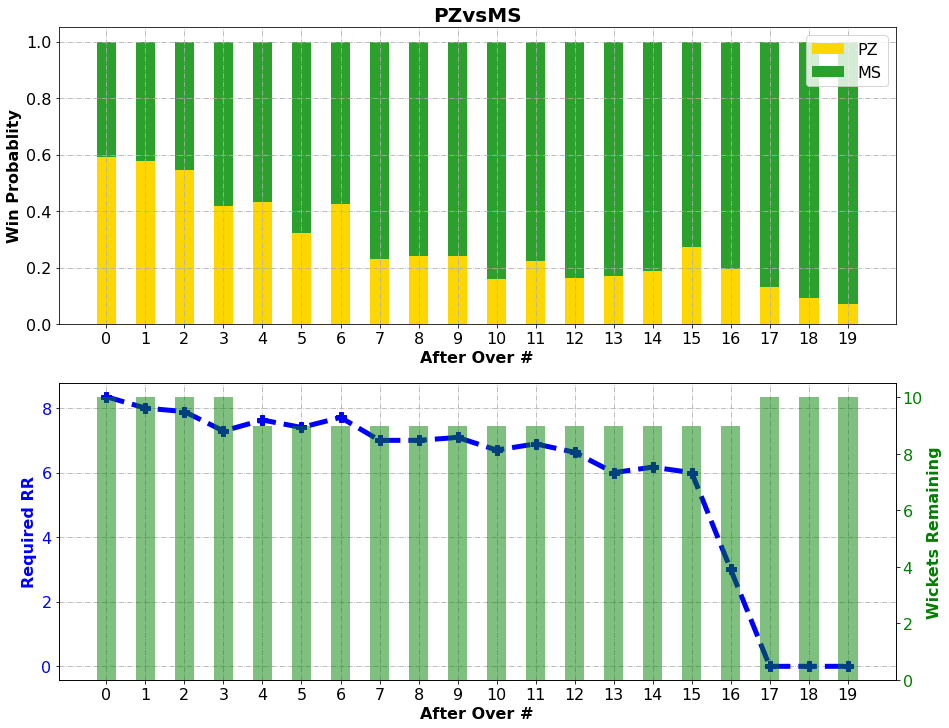

In [8]:
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,12))

ax1.bar(np.arange(20), Team1_prob[0:20], width, label=Team1, color='gold')
ax1.bar(np.arange(20), Team2_prob[0:20], width, bottom=Team1_prob[0:20],
       label=Team2, color='tab:green')

ax1.set_ylabel('Win Probablity', fontsize=16, fontweight='bold')
ax1.set_xlabel('After Over #', fontsize=16, fontweight='bold')
ax1.set_title(str('%svs%s'%(Team1,Team2)), fontsize=20, fontweight='bold')
ax1.legend(fontsize=16)
ax1.set_xticks(np.arange(20))
ax1.tick_params(labelsize=16)

ax2.plot(np.arange(20),RRR[0:20], 'bP--', label='Required RR',linewidth=5.0, fillstyle='full', markersize=10)



ax2.set_xlabel('After Over #', fontsize=16, fontweight='bold')
ax3 = ax2.twinx()
ax3.bar(np.arange(20),np.asarray(Wkts).flatten()[0:20], width, label='Wkt Rem.', color='green', alpha=0.5)

#ax2.set_title(str('%svs%s'%(Team1,Team2)), fontsize=16, fontweight='bold')
ax2.set_xticks(np.arange(20))
ax2.tick_params(axis = 'y', labelsize=16, labelcolor='blue')
ax2.tick_params(axis = 'x', labelsize=16, labelcolor='black')
ax2.set_ylabel('Required RR', fontsize=16, fontweight='bold',color='blue')

ax3.tick_params(labelsize=16, labelcolor='green')
ax3.set_ylabel('Wickets Remaining', fontsize=16, fontweight='bold', color='green')

ax1.grid(linestyle='-.')
ax2.grid(linestyle='-.')
plt.show()